In [3]:
from xgboost import XGBClassifier
import warnings
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from tabpfn_new.scripts.transformer_prediction_interface import TabPFNClassifier, MedPFNClassifier
from tabpfn_new.scripts.model_builder import load_model
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from data_prep_utils import *
from evaluate import *
from load_models import *
import matplotlib.pyplot as plt
import torch
import openml
import time
import matplotlib as mpl
#from autogluon.tabular import TabularDataset, TabularPredictor
pd.set_option('display.expand_frame_repr', False)

In [4]:
path = "datasets/data_all.csv"
all_data, labels = get_microbiome(path)
all_data = remove_zero_features(all_data)
all_data, labels = unison_shuffled_copies(all_data, labels, seed=45)
#all_data = top_anova(all_data, labels)

In [ ]:
red_name ="fi-loco"
m = "rocs"
file1 = np.load(f"results/{red_name}/extranew_{m}1.npy")

In [ ]:
best = np.argsort(file1)

In [ ]:
all_data = np.delete(all_data, best[:500], axis=1)

## Baseline 

In [ ]:
save = False
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 40
ft_epochs_forest = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
preprocess_mode = 'mix'
multi_decoder = "permutation"
N_ens = 10
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
#run_name = "medium_net_mlp_balance_bsplit_baseline" ## NO PERM, VERY ROBUST
#run_name2 = "large_mlp_var_balance_05weight_anova" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
run_name = "small_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## good start, best with ft
#run_name = "large_mlp_var_balance_05weight_anova_bestwithnoisebnn_100_moreweight" ## best start, ft no so good
#run_name = "medium_mlp_var_balance_05weight_anova_200" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_longer" ## das aller bestigste
#run_name = "medium_mlp_balance_lownoisefixparam_anova"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight" ## WORKS VERY WELL WITH PERM
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
#path2 = dir_path + f"/logs/trainrun_{run_name2}"
#path3 = dir_path + f"/logs/trainrun_{run_name3}"
filename = "model"



models = [
    MajorityClass(),
    XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=1, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  preprocess_mode=preprocess_mode),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  preprocess_mode=preprocess_mode,
                    ft_epochs=ft_epochs, ft_lr=ft_lr),
    RandomForestClassifier(),
    #AutoGluon(),
    CatBoostGrid(),
    XGBoostGrid(),
    LogisticRegressionClassifier(), 
    TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs_forest)
]
reducer  = AnovaSelect(k=5)


results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                            index=[m.__class__.__name__ for m in models],
                            columns=metrics+["runtime"])
results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                           index=[m.__class__.__name__ for m in models],
                           columns=metrics+["runtime"])

for ii, model in enumerate(models):
    results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
        model, all_data, labels, metrics, strat_split, cv, sampling, 
        reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
        recomp=recomp)

results_mean = results_mean.add_suffix(" mean")
results_std = results_std.add_suffix(" std")
results_full = pd.concat((results_mean, results_std), axis=1)
cols = results_full.columns.tolist()
new_cols = []
for i in range(int(len(cols)/2)):
    new_cols.append(cols[i])
    new_cols.append(cols[i+int(len(cols)/2)])
results_full = results_full[new_cols]
red_name = reducer.__class__.__name__
if save:
    directory = f"results/{red_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    save_path = f'results/{red_name}/baseline_cv{cv}_mxsamp{max_samples}_sd{seed}_ovrw{int(overwrite)}.csv'
    results_full.to_csv(save_path)
print("\n", results_full.round(3))
#print(results_full.sort_values("roc_auc mean").round(3))

## Baseline Repeated cross validation

In [ ]:
save = False
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 10
ft_epochs_forest = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
preprocess_mode = 'mix'
multi_decoder = "permutation"
N_ens = 5
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
#run_name = "medium_net_mlp_balance_bsplit_baseline" ## NO PERM, VERY ROBUST
#run_name2 = "large_mlp_var_balance_05weight_anova" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
run_name = "small_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## good start, best with ft
run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## good start, best with ft
#run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100_moreweight" ## best start, ft no so good
#run_name = "medium_mlp_var_balance_05weight_anova_200" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_longer" ## das aller bestigste
#run_name = "medium_mlp_balance_lownoisefixparam_anova"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight" ## WORKS VERY WELL WITH PERM
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
#path2 = dir_path + f"/logs/trainrun_{run_name2}"
#path3 = dir_path + f"/logs/trainrun_{run_name3}"
filename = "model"



models = [
    MajorityClass(),
    XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=1, multiclass_decoder=multi_decoder,  preprocess_mode=preprocess_mode),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  preprocess_mode=preprocess_mode),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  preprocess_mode=preprocess_mode,
                    ft_epochs=ft_epochs, ft_lr=ft_lr),
    RandomForestClassifier(),
    #AutoGluon(),
    #CatBoostGrid(),
    #XGBoostGrid(),
    LogisticRegressionClassifier(), 
    #TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    #TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs_forest)
]
reducer  = AnovaSelect()




    
results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                            index=[m.__class__.__name__ for m in models],
                            columns=metrics+["runtime"])
results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                           index=[m.__class__.__name__ for m in models],
                           columns=metrics+["runtime"])

size = min(labels.shape[0],np.floor(max_samples*(cv/(cv-1))))
runs = int(all_data.shape[0]//size)
data_sections, label_sections = stratified_split(all_data, labels,cv=runs)



for section in range(runs):
    print("Step: ", section)
    for ii, model in enumerate(models):
        out_mean, out_std = cross_validate_sample(
            model, data_sections[section], label_sections[section], metrics, strat_split, cv, sampling, 
            reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
            recomp=recomp)
        results_mean.iloc[ii,:] += out_mean
        results_std.iloc[ii,:] += out_std 
    
results_mean = results_mean.add_suffix(" mean")
results_std = results_std.add_suffix(" std")
results_full = pd.concat((results_mean, results_std), axis=1)
cols = results_full.columns.tolist()
new_cols = []
for i in range(int(len(cols)/2)):
    new_cols.append(cols[i])
    new_cols.append(cols[i+int(len(cols)/2)])
results_full = results_full[new_cols]
results_full = results_full/runs
red_name = "repeated_cv"
if save:
    directory = f"results/{red_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    save_path = f'results/{red_name}/2ndedit_baseline_cv{cv}_mxsamp{max_samples}_sd{seed}_ovrw{int(overwrite)}.csv'
    results_full.to_csv(save_path)
print("\n", "\n", red_name, "\n", results_full.round(3))
#print(results_full.sort_values("roc_auc mean").round(3))

1.5609914672374723
                      Unnamed: 0  accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std   f1 mean    f1 std  runtime mean  runtime std
2               MedPFNClassifier       0.948839      0.010036        0.550500       0.308217     0.221667    0.129895      0.829104     0.083158  0.296705  0.159137      0.037149     0.005193
3               MedPFNClassifier       0.957768      0.010924        0.748000       0.296675     0.293333    0.164146      0.862060     0.079942  0.401755  0.193619      0.753458     0.090357
4               MedPFNClassifier       0.957143      0.011232        0.741738       0.292205     0.310000    0.161323      0.860865     0.080151  0.415647  0.181615      2.900851     0.286368
5         RandomForestClassifier       0.953839      0.010317        0.655167       0.380659     0.206667    0.141835      0.849717     0.087282  0.301399  0.192039      0.194305     0.007029
6                   C

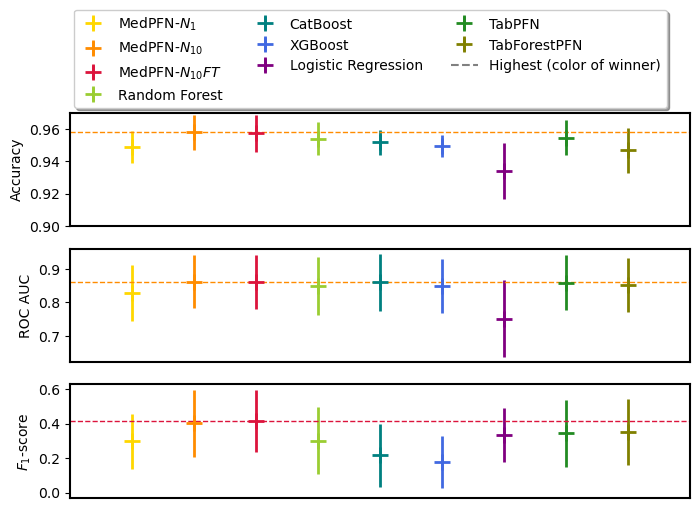

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [13]:
save_path = f'results/repeated_cv/2ndedit_baseline_cv10_mxsamp1024_sd42_ovrw1.csv'
data = pd.read_csv(save_path)
#data.round(3).to_csv(f'results/repeated_cv/rounded_2ndedit_baseline_cv10_mxsamp1024_sd42_ovrw1.csv')
rows = [2,3,4,5,6,7,8,9,10]
names = [r"MedPFN-$N_1$", r"MedPFN-$N_{10}$", r"MedPFN-$N_{10}FT$", "Random Forest", "CatBoost", "XGBoost", "Logistic Regression", "TabPFN", "TabForestPFN"]
times = data.iloc[:,-2]
print(np.sum(times)*100/3600)
data = data.iloc[rows,:]
print(data)
fig, axs = plt.subplots(3, 1, figsize=(8, 5), dpi=100, sharex=True)
print()
# Plot error bar plots in each subplot
models = data.iloc[:,0].values
colors = ["gold", "darkorange", "crimson", "yellowgreen", "teal", "royalblue", "purple", "forestgreen", "olive"]
#print(models)
x = np.arange(len(data.iloc[:,1].values))
for i in range(len(models)):
    axs[0].set_xticks([])
    axs[0].set_xlim(-1,len(rows))
    axs[0].errorbar(x[i], data.iloc[i,1], yerr=data.iloc[i,2], fmt='+', mew=2, lw=2, markersize=12, capsize=0, color=colors[i], label=names[i])
    axs[0].set_ylabel("Accuracy")
    
    axs[1].errorbar(x[i], data.iloc[i,7], yerr=data.iloc[i,8], fmt='+', mew=2, lw=2, markersize=12, capsize=0, color=colors[i])
    axs[1].set_ylabel("ROC AUC")
    #axs[1].legend()
    
    axs[2].errorbar(x[i], data.iloc[i,9], yerr=data.iloc[i,10], fmt='+', mew=2, lw=2, markersize=12, capsize=0, color=colors[i])
    axs[2].set_ylabel(r"$F_1$-score")
    #axs[2].legend()
    
    #axs[3].errorbar(x[i], data.iloc[i,7], yerr=data.iloc[i,8], fmt='+', mew=2, lw=2, markersize=12, capsize=0, color=colors[i])
    #axs[3].set_ylabel("")
    #axs[3].legend()
    
    # Set common x-axis label
    #axs[3].set_xlabel("X-axis")

inds = [1,7,9]
for j in range(3):
    #print(data.columns[1+2*j])
    #print(data.iloc[:,1+2*j].values,np.argmax(data.iloc[:,1+2*j].values))
    axs[j].hlines(np.max(data.iloc[:,inds[j]].values),-1,len(rows), lw=1, colors=colors[np.argmax(data.iloc[:,inds[j]].values)], linestyles="dashed")
    #axs[j].grid()
axs[j].hlines(0,0,0,linestyles="dashed", colors=["gray"], label="Highest (color of winner)")
axs[0].set_ylim(0.9,0.97)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)
# Adjust layout to prevent overlap
#plt.tight_layout()
plt.show()
fig.savefig("results/plots/baselinecompare.eps", bbox_inches='tight')

## Mine vs static vs normal

In [ ]:
save = True
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 20
ft_epochs_forest = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 5
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "small_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" 
run_name2 = "small_mlp_static_balance_05weight_anova_bestwithnoisebnn_100" 
run_name3 = "small_mlp_var_balance_05weight_anova_bestwithnoisebnn_100_normalprior" 
path = dir_path + f"/logs/trainrun_{run_name}"
path2 = dir_path + f"/logs/trainrun_{run_name2}"
path3 = dir_path + f"/logs/trainrun_{run_name3}"
filename = "model"


models = [
    
    #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    #MedPFNClassifier(base_path=path2, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    #MedPFNClassifier(base_path=path3, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  preprocess_mode=preprocess_mode, ft_epochs=ft_epochs, ft_lr=ft_lr),
    MedPFNClassifier(base_path=path2, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  preprocess_mode=preprocess_mode,ft_epochs=ft_epochs, ft_lr=ft_lr),
    MedPFNClassifier(base_path=path3, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  preprocess_mode=preprocess_mode,ft_epochs=ft_epochs, ft_lr=ft_lr),
]
reducer  = AnovaSelect()
#for reducer in [AnovaSelect(), RandomSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
#data = clr(all_data)

#all_data = normalize(all_data)

results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                            index=[m.__class__.__name__ for m in models],
                            columns=metrics+["runtime"])
results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                           index=[m.__class__.__name__ for m in models],
                           columns=metrics+["runtime"])

for ii, model in enumerate(models):
    results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
        model, all_data, labels, metrics, strat_split, cv, sampling, 
        reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
        recomp=recomp)

results_mean = results_mean.add_suffix(" mean")
results_std = results_std.add_suffix(" std")
results_full = pd.concat((results_mean, results_std), axis=1)
cols = results_full.columns.tolist()
new_cols = []
for i in range(int(len(cols)/2)):
    new_cols.append(cols[i])
    new_cols.append(cols[i+int(len(cols)/2)])
results_full = results_full[new_cols]
red_name = "nomethodscompare"
if save:
    directory = f"results/{red_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    save_path = f'results/{red_name}/results_1mine_2staticbal_3normalprior.csv'
    results_full.to_csv(save_path)
print("\n", "\n", red_name, "\n", results_full.round(3))
#print(results_full.sort_values("roc_auc mean").round(3))

In [12]:
save_path = f'results/repeated_cv/medium_baseline_cv10_mxsamp1024_sd42_ovrw1.csv'
df = pd.read_csv(save_path)
save_path = f'results/repeated_cv/rounded_medium_baseline_cv10_mxsamp1024_sd42_ovrw1.csv'
df.round(3).to_csv(save_path)
print(df.round(3))

         Unnamed: 0  accuracy mean  accuracy std  precision mean  precision std  recall mean  recall std  roc_auc mean  roc_auc std  f1 mean  f1 std  runtime mean  runtime std
0  MedPFNClassifier          0.949         0.010           0.550          0.308        0.222       0.130         0.829        0.083    0.297   0.159         0.037        0.005
1  MedPFNClassifier          0.958         0.011           0.748          0.297        0.293       0.164         0.862        0.080    0.402   0.194         0.753        0.090
2  MedPFNClassifier          0.957         0.011           0.742          0.292        0.310       0.161         0.861        0.080    0.416   0.182         2.901        0.286


## Context length

In [ ]:
save = True
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 20
ft_epochs_forest = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 10
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
#run_name = "medium_net_mlp_balance_bsplit_baseline" ## NO PERM, VERY ROBUST
#run_name2 = "large_mlp_var_balance_05weight_anova" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## good start, best with ft
#run_name3 = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100_moreweight" ## best start, ft no so good
#run_name = "medium_mlp_var_balance_05weight_anova_200" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_longer" ## das aller bestigste
#run_name = "medium_mlp_balance_lownoisefixparam_anova"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight" ## WORKS VERY WELL WITH PERM
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
#path2 = dir_path + f"/logs/trainrun_{run_name2}"
#path3 = dir_path + f"/logs/trainrun_{run_name3}"
filename = "model"

lengths = [512,1024,2048,4096,8192]

models = [
    MajorityClass(),
    XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=1, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process,
                    ft_epochs=ft_epochs, ft_lr=ft_lr),
    RandomForestClassifier(),
    #AutoGluon(),
    CatBoostGrid(),
    XGBoostGrid(),
    LogisticRegressionClassifier(), 
    TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs_forest)
]
reducer  = AnovaSelect()
#for reducer in [AnovaSelect(), RandomSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
#data = clr(all_data)

#all_data = normalize(all_data)

for cl in lengths:
    results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                index=[m.__class__.__name__ for m in models],
                                columns=metrics+["runtime"])
    results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                               index=[m.__class__.__name__ for m in models],
                               columns=metrics+["runtime"])
    
    size = min(labels.shape[0],np.floor(max_samples*(cv/(cv-1))))
    runs = int(all_data.shape[0]//size)
    data_sections, label_sections = stratified_split(all_data, labels,cv=runs)
    for section in range(runs):
    print("Step: ", section)
    for ii, model in enumerate(models):
        out_mean, out_std = cross_validate_sample(
            model, data_sections[section], label_sections[section], metrics, strat_split, cv, sampling, 
            reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
            recomp=recomp)
        results_mean.iloc[ii,:] += out_mean
        results_std.iloc[ii,:] += out_std 
    
    results_mean = results_mean.add_suffix(" mean")
    results_std = results_std.add_suffix(" std")
    results_full = pd.concat((results_mean, results_std), axis=1)
    cols = results_full.columns.tolist()
    new_cols = []
    for i in range(int(len(cols)/2)):
        new_cols.append(cols[i])
        new_cols.append(cols[i+int(len(cols)/2)])
    results_full = results_full[new_cols]
    results_full = results_full/runs
    red_name = "context_length"
    if save:
        directory = f"results/{red_name}"
        if not os.path.exists(directory):
            os.makedirs(directory)
        save_path = f'results/{red_name}/context_length_{cl}.csv'
        results_full.to_csv(save_path)
    print("\n", "\n", red_name, "\n", results_full.round(3))
    #print(results_full.sort_values("roc_auc mean").round(3))

In [ ]:

models = ["Majclass", "MedPFN-1", "MedPFN-7", "MedPFN-7FT", "RandomForest", "CatBoost", "XGBoost", "Logistic Regression", "TabPFN", "TabForestPFN"]
fig, axs = plt.subplots(1,1,figsize=(10,5))#plt.subplots(1, 3, figsize=(25, 5))
all_accuracies = []
all_rocs = []
all_f1s = []
lengths = [512,1024,2048,4096,8192]
for m in range(1,len(models)):
    accuracies = []
    rocs = []
    f1s = []
    for cl in lengths:
    
        path = f'results/context_length/context_length_{cl}.csv'
        df = pd.read_csv(path)
        accuracies.append(df.iloc[m,1])
        rocs.append(df.iloc[m,7])
        f1s.append(df.iloc[m,9])
    all_accuracies.append(accuracies)
    all_rocs.append(rocs)
    all_f1s.append(f1s)
    
#axs[0].plot(all_accuracies[3])
#axs[1].plot(all_rocs[3])
#axs[2].plot(all_f1s[2])
mean_accuracies = all_accuracies[3]-np.max(np.array(all_accuracies)[4:],axis=0)
#axs.plot(fracs, mean_accuracies)
mean_rocs = all_rocs[3]-np.max(np.array(all_rocs)[4:],axis=0)
#axs.plot(fracs, mean_rocs)
mean_f1s = all_f1s[3]-np.max(np.array(all_f1s)[4:],axis=0)
#axs.plot(fracs, mean_f1s)
axs.plot(lengths, np.zeros(len(lengths)), linestyle='--', c="black", label="Win threshhold")
axs.plot(lengths, mean_rocs, marker="v", linewidth=2.5, markersize=7.0, label='ROC AUC', c="darkviolet")
axs.plot(lengths, mean_accuracies, marker="v", linewidth=2.5, markersize=7.0, label='Accuracy', c="crimson")
axs.plot(lengths, mean_f1s, marker="v", linewidth=2.5, markersize=7.0, label='F1-score', c="limegreen")
#axs.set_yticks([-0.05,0,0.05,0.1])
#axs.set_xlim(0.5,0.94)
axs.set_xlabel("Fraction of class 0 in data")
axs.set_ylabel("MedPFN - mean[baselines]")
axs.grid()
axs.legend(fontsize=12)
fig.show()


'''df = pd.read_csv(path)
        accuracies.append(df.iloc[m,1])
        rocs.append(df.iloc[m,7])
        f1s.append(df.iloc[m,9])
    axs[0].plot(lengths, accuracies)
    axs[1].plot(lengths, rocs, label = models[m])
    axs[2].plot(lengths, f1s)
    
axs[1].legend(fontsize=12)
fig.show()'''

## Imbalance anaysis

In [5]:
save = True
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 20
ft_epochs_forest = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 5
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
#run_name = "medium_net_mlp_balance_bsplit_baseline" ## NO PERM, VERY ROBUST
#run_name2 = "large_mlp_var_balance_05weight_anova" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## good start, best with ft
#run_name3 = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100_moreweight" ## best start, ft no so good
#run_name = "medium_mlp_var_balance_05weight_anova_200" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_longer" ## das aller bestigste
#run_name = "medium_mlp_balance_lownoisefixparam_anova"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight" ## WORKS VERY WELL WITH PERM
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
#path2 = dir_path + f"/logs/trainrun_{run_name2}"
#path3 = dir_path + f"/logs/trainrun_{run_name3}"
filename = "model"



models = [
    MajorityClass(),
    XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=1, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process,
                    ft_epochs=ft_epochs, ft_lr=ft_lr),
    RandomForestClassifier(),
    #AutoGluon(),
    CatBoostGrid(),
    XGBoostGrid(),
    LogisticRegressionClassifier(), 
    TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs_forest)
]
reducer  = AnovaSelect()
#for reducer in [AnovaSelect(), RandomSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
#data = clr(all_data)

#all_data = normalize(all_data)

frac = [0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]
for f in frac:
    data_c0 = all_data[labels==0]
    data_c1 = all_data[labels==1]
    num_c1 = data_c1.shape[0]
    num_c0 = min(int(num_c1*f/(1-f)),data_c0.shape[0])
    num_c1 = min(num_c1, int(num_c0*(1-f)/f))
    print(num_c1,num_c0)
    data = np.concatenate((data_c0[:num_c0], data_c1[:num_c1]), axis=0)
    print(data.shape)
    labels_new = np.concatenate((np.zeros(num_c0), np.ones(num_c1)))
    data_new, labels_new = unison_shuffled_copies(data, labels_new)
    counts = np.unique(labels_new, return_counts=True)[1]
    print(counts[0]/np.sum(counts))
    results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                index=[m.__class__.__name__ for m in models],
                                columns=metrics+["runtime"])
    results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                               index=[m.__class__.__name__ for m in models],
                               columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
            model, data_new, labels_new, metrics, strat_split, cv, sampling, 
            reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
            recomp=recomp)
    
    results_mean = results_mean.add_suffix(" mean")
    results_std = results_std.add_suffix(" std")
    results_full = pd.concat((results_mean, results_std), axis=1)
    cols = results_full.columns.tolist()
    new_cols = []
    for i in range(int(len(cols)/2)):
        new_cols.append(cols[i])
        new_cols.append(cols[i+int(len(cols)/2)])
    results_full = results_full[new_cols]
    red_name = "imbalance"
    if save:
        directory = f"results/{red_name}"
        if not os.path.exists(directory):
            os.makedirs(directory)
        save_path = f'results/{red_name}/majclass_{f}.csv'
        results_full.to_csv(save_path)
    print("\n", "\n", red_name, "\n", results_full.round(3))
    #print(results_full.sort_values("roc_auc mean").round(3))

TypeError: MedPFNClassifier.__init__() got an unexpected keyword argument 'no_preprocess_mode'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0.9388413889373582
[0.8775191326530611, 0.8638142620232173, 0.8974299961641734, 0.9023400673400672, 0.899072265625, 0.8932493249324933, 0.8744934640522876, 0.8697458791208792, 0.8550340136054421, 0.8720754716981132, 0.8656178608515057, 0.8744598765432099, 0.8420319401970777, 0.8256565656565658, 0.875975975975976]
[0.9208864795918366, 0.9324378109452734, 0.9088224012274646, 0.9126599326599326, 0.9026204427083332, 0.8953345334533452, 0.8785294117647059, 0.8762534340659339, 0.8556632653061225, 0.8767059748427674, 0.8701869158878506, 0.8786522633744857, 0.8521661569826708, 0.8284217171717172, 0.8624624624624624]


C:\Users\lenna\AppData\Local\Temp\ipykernel_18540\4088689394.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


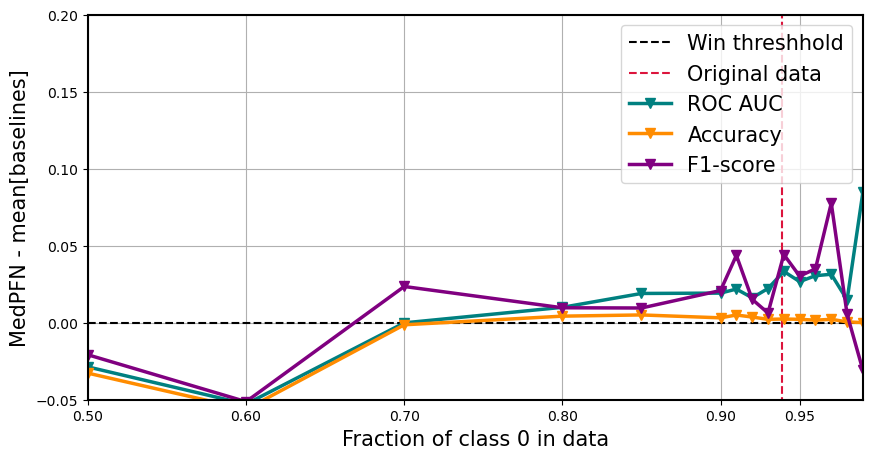

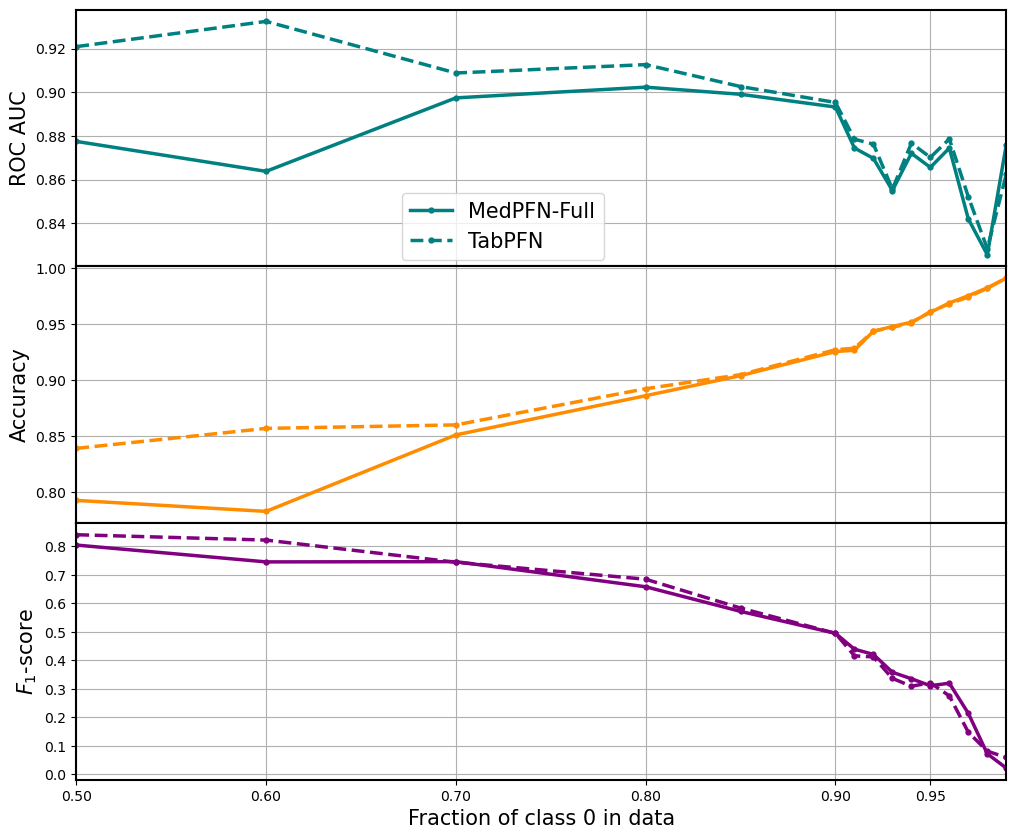

In [9]:
data_imb = all_data[labels==0].shape[0]/(all_data[labels==0].shape[0]+all_data[labels==1].shape[0])
print(data_imb)
#models = ["Majclass", "MedPFN-1", "MedPFN-7", "MedPFN-7FT", "RandomForest", "CatBoost", "XGBoost", "Logistic Regression", "TabPFN", "TabForestPFN"]
models = ["XGBoost", "MedPFN-Full", "MedPFN-Balance", "Random Forest","Logistic Regression", "TabPFN"]
mpl.rcParams['axes.linewidth'] = 1.5
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
all_accuracies = []
all_rocs = []
all_f1s = []
fracs = [0.5,0.6,0.7,0.8,0.85,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99]
for m in range(0,len(models)):
    accuracies = []
    rocs = []
    f1s = []
    for f in fracs:
    
        path = f'results/imbalance/new2_medium_majclass_{f}.csv'
        df = pd.read_csv(path)
        accuracies.append(df.iloc[m,1])
        rocs.append(df.iloc[m,7])
        f1s.append(df.iloc[m,9])
    all_accuracies.append(accuracies)
    all_rocs.append(rocs)
    all_f1s.append(f1s)
    
#axs[0].plot(all_accuracies[3])
#axs[1].plot(all_rocs[3])
#axs[2].plot(all_f1s[2])
base = [0,3,5]
mean_accuracies = all_accuracies[1]-np.mean(np.array(all_accuracies)[base],axis=0)
#axs.plot(fracs, mean_accuracies)
mean_rocs = all_rocs[1]-np.mean(np.array(all_rocs)[base],axis=0)
#axs.plot(fracs, mean_rocs)
mean_f1s = all_f1s[1]-np.mean(np.array(all_f1s)[base],axis=0)
#axs.plot(fracs, mean_f1s)
colors = ["teal", "darkorange", "purple"]
axs.plot(fracs, np.zeros(len(fracs)), linestyle='--', c="black", label="Win threshhold")
axs.vlines(data_imb,-0.075,0.25, linestyles="dashed", colors="crimson", label="Original data")
axs.plot(fracs, mean_rocs, marker="v", linewidth=2.5, markersize=7.0, label='ROC AUC', c="teal")
axs.plot(fracs, mean_accuracies, marker="v", linewidth=2.5, markersize=7.0, label='Accuracy', c="darkorange")
axs.plot(fracs, mean_f1s, marker="v", linewidth=2.5, markersize=7.0, label='F1-score', c="purple")
#for ii, m in enumerate(models):


mpl.rcParams['axes.linewidth'] = 1.5
heights = [1,1,1]
fig1,ax = plt.subplots(3,1,figsize=(12,10), gridspec_kw={'height_ratios': heights}, sharex=True, dpi=100)
plt.subplots_adjust(hspace=0)
styles = ["solid",'dashed', "dotted"]
for s, ii in enumerate([1,5]):
    print(all_rocs[ii])
    ax[1].plot(fracs, all_accuracies[ii], marker=".", linewidth=2.5, markersize=7.0, linestyle=styles[s], label=models[ii], c="darkorange")
    ax[0].plot(fracs, all_rocs[ii], marker=".", linewidth=2.5, markersize=7.0, linestyle=styles[s], label=models[ii], c="teal")
    ax[2].plot(fracs, all_f1s[ii], marker=".", linewidth=2.5, markersize=7.0, linestyle=styles[s], label=models[ii], c="purple")
#axs.plot(fracs, all_rocs[5], marker="v", linewidth=2.5, markersize=7.0, label='Accuracy', c="darkorange")
metrics = ["ROC AUC", "Accuracy", r"$F_1$-score"]
for x in range(3):
    ax[x].grid()
    ax[x].set_ylabel(metrics[x], fontsize=15)
#axs.set_yticks([-0.05,0,0.05,0.1])
axs.set_ylim(-0.05,0.2)
axs.set_xlim(0.5,0.99)
axs.set_xticks([0.5,0.6,0.7,0.8,0.9,0.95])
ax[0].set_xlim(0.5,0.99)
ax[0].set_xticks([0.5,0.6,0.7,0.8,0.9,0.95])
ax[0].legend(loc=(0.35,0.025), fontsize=15)
ax[2].set_xlabel("Fraction of class 0 in data", fontsize=15)
axs.set_xlabel("Fraction of class 0 in data", fontsize=15)
axs.set_ylabel("MedPFN - mean[baselines]", fontsize=15)
axs.grid()
axs.legend(fontsize=15)
fig.savefig("results/plots/imbalance.eps")
fig1.show()
fig1.savefig("results/plots/imbalance2.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
C:\Users\lenna\AppData\Local\Temp\ipykernel_18540\2339772843.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0.028629856850715747
[0.8073820754716982, 0.7866981132075472, 0.7534669811320753, 0.7622641509433963, 0.7961871069182389, 0.7801336477987422, 0.8037657232704403, 0.7889779874213838]
[0.8563522012578618, 0.844308176100629, 0.8253694968553459, 0.8158805031446541, 0.8244968553459119, 0.8352201257861636, 0.8410534591194969, 0.8348270440251573]
[0.8565408805031446, 0.8452358490566038, 0.8217688679245283, 0.8194811320754717, 0.82062893081761, 0.8308805031446541, 0.8443238993710691, 0.8425786163522012]


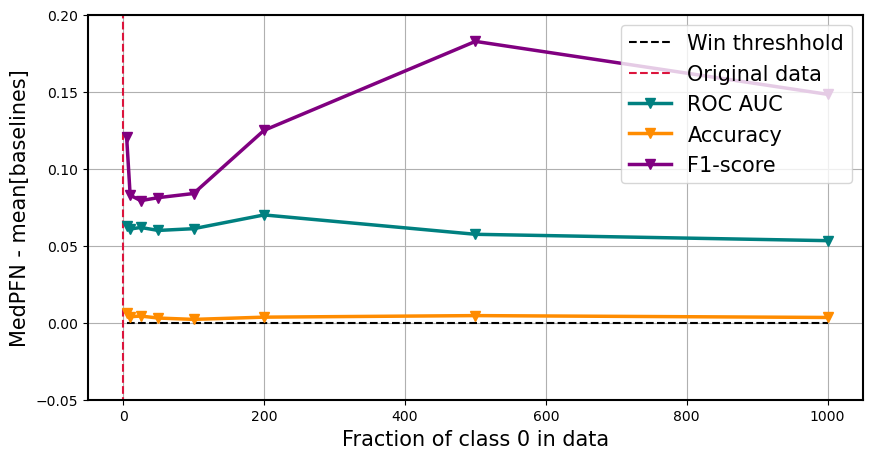

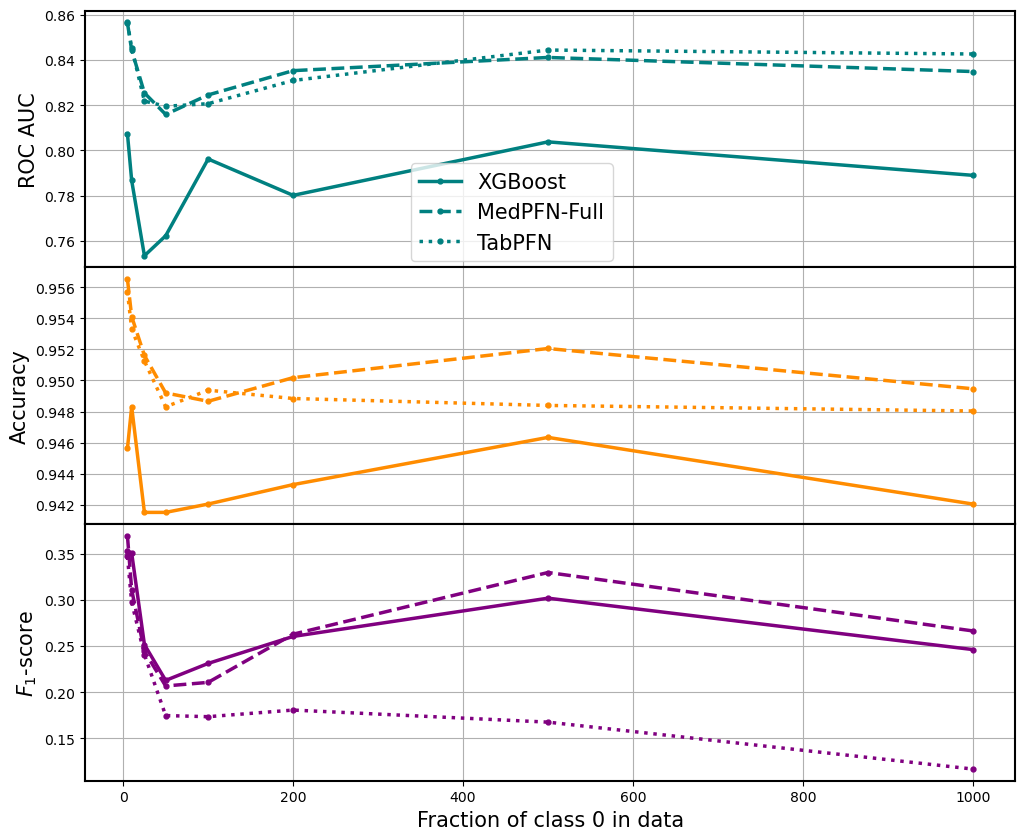

In [43]:
data_imb = all_data[labels==0].shape[0]/(all_data[labels==0].shape[0]+all_data[labels==1].shape[0])
print(data_imb)
#models = ["Majclass", "MedPFN-1", "MedPFN-7", "MedPFN-7FT", "RandomForest", "CatBoost", "XGBoost", "Logistic Regression", "TabPFN", "TabForestPFN"]
models = ["XGBoost", "MedPFN-Full", "Random Forest","Logistic Regression", "TabPFN"]
mpl.rcParams['axes.linewidth'] = 1.5
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
all_accuracies = []
all_rocs = []
all_f1s = []
shifts = [5,10,25,50,100,200,500,1000]
for m in range(0,len(models)):
    accuracies = []
    rocs = []
    f1s = []
    for s in shifts:
    
        path = f'results/fi_shift/new2_medium_shift_{s}.csv'
        df = pd.read_csv(path)
        accuracies.append(df.iloc[m,1])
        rocs.append(df.iloc[m,7])
        f1s.append(df.iloc[m,9])
    all_accuracies.append(accuracies)
    all_rocs.append(rocs)
    all_f1s.append(f1s)
    
#axs[0].plot(all_accuracies[3])
#axs[1].plot(all_rocs[3])
#axs[2].plot(all_f1s[2])
base = [0,2,3,4]
mean_accuracies = all_accuracies[1]-np.mean(np.array(all_accuracies)[base],axis=0)
#axs.plot(fracs, mean_accuracies)
mean_rocs = all_rocs[1]-np.mean(np.array(all_rocs)[base],axis=0)
#axs.plot(fracs, mean_rocs)
mean_f1s = all_f1s[1]-np.mean(np.array(all_f1s)[base],axis=0)
#axs.plot(fracs, mean_f1s)
colors = ["teal", "darkorange", "purple"]
axs.plot(shifts, np.zeros(len(shifts)), linestyle='--', c="black", label="Win threshhold")
axs.vlines(data_imb,-0.075,0.25, linestyles="dashed", colors="crimson", label="Original data")
axs.plot(shifts, mean_rocs, marker="v", linewidth=2.5, markersize=7.0, label='ROC AUC', c="teal")
axs.plot(shifts, mean_accuracies, marker="v", linewidth=2.5, markersize=7.0, label='Accuracy', c="darkorange")
axs.plot(shifts, mean_f1s, marker="v", linewidth=2.5, markersize=7.0, label='F1-score', c="purple")
#for ii, m in enumerate(models):


mpl.rcParams['axes.linewidth'] = 1.5
heights = [1,1,1]
fig1,ax = plt.subplots(3,1,figsize=(12,10), gridspec_kw={'height_ratios': heights}, sharex=True, dpi=100)
plt.subplots_adjust(hspace=0)
styles = ["solid",'dashed', "dotted"]
for s, ii in enumerate([0,1,4]):
    print(all_rocs[ii])
    ax[1].plot(shifts, all_accuracies[ii], marker=".", linewidth=2.5, markersize=7.0, linestyle=styles[s], label=models[ii], c="darkorange")
    ax[0].plot(shifts, all_rocs[ii], marker=".", linewidth=2.5, markersize=7.0, linestyle=styles[s], label=models[ii], c="teal")
    ax[2].plot(shifts, all_f1s[ii], marker=".", linewidth=2.5, markersize=7.0, linestyle=styles[s], label=models[ii], c="purple")
#axs.plot(fracs, all_rocs[5], marker="v", linewidth=2.5, markersize=7.0, label='Accuracy', c="darkorange")
metrics = ["ROC AUC", "Accuracy", r"$F_1$-score"]
for x in range(3):
    ax[x].grid()
    ax[x].set_ylabel(metrics[x], fontsize=15)
#axs.set_yticks([-0.05,0,0.05,0.1])
axs.set_ylim(-0.05,0.2)
#axs.set_xlim(0.5,0.99)
#axs.set_xticks([0.5,0.6,0.7,0.8,0.9,0.95])
#ax[0].set_xlim(0.5,0.99)
#ax[0].set_xticks([0.5,0.6,0.7,0.8,0.9,0.95])
ax[0].legend(loc=(0.35,0.025), fontsize=15)
ax[2].set_xlabel("Fraction of class 0 in data", fontsize=15)
axs.set_xlabel("Fraction of class 0 in data", fontsize=15)
axs.set_ylabel("MedPFN - mean[baselines]", fontsize=15)
axs.grid()
axs.legend(fontsize=15)
fig.savefig("results/plots/fi_shift.eps")
fig1.show()
fig1.savefig("results/plots/fi_shift2.eps")

## Ensemble testing

In [ ]:
save = True
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 0
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 5
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "small_mlp_var_balance_05weight_anova_bestwithnoisebnn_100"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"


enses = [25,40,50]
ens_num = len(enses)


reducer  = AnovaSelect()

results_mean = pd.DataFrame(np.zeros((ens_num, len(metrics)+1)),
                            index=np.arange(1,1+ens_num),
                            columns=metrics+["runtime"])
results_std = pd.DataFrame(np.zeros((ens_num, len(metrics)+1)),
                           index=np.arange(1,1+ens_num),
                           columns=metrics+["runtime"])

for nens in range(1,ens_num+1):
    #print(nens)
    model = MedPFNClassifier(base_path=path, filename=filename, device=device, N_ensemble_configurations=enses[nens-1], multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process)

    size = min(labels.shape[0],np.floor(max_samples*(cv/(cv-1))))
    runs = int(all_data.shape[0]//size)
    data_sections, label_sections = stratified_split(all_data, labels,cv=runs)
    #print(np.array(data_sections).shape, size)

    for section in range(runs):
        out_mean, out_std = cross_validate_sample(
            model, data_sections[section], label_sections[section], metrics, strat_split, cv, sampling,
            reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
            recomp=recomp)
        results_mean.iloc[nens-1,:] += out_mean
        results_std.iloc[nens-1,:] += out_std

###
results_mean=results_mean/runs
results_std=results_std/runs
results_mean = results_mean.add_suffix(" mean")
results_std = results_std.add_suffix(" std")
results_full = pd.concat((results_mean, results_std), axis=1)
cols = results_full.columns.tolist()
new_cols = []
for i in range(int(len(cols)/2)):
    new_cols.append(cols[i])
    new_cols.append(cols[i+int(len(cols)/2)])
results_full = results_full[new_cols]
red_name = "ensemble"
if save:
    directory = f"results/{red_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    save_path = f'results/{red_name}/medpfn_maxens{ens_num}'
    results_full.to_csv(save_path)
print("\n", "\n", red_name, "\n", results_full.round(3))
#print(results_full.sort_values("roc_auc mean").round(3))

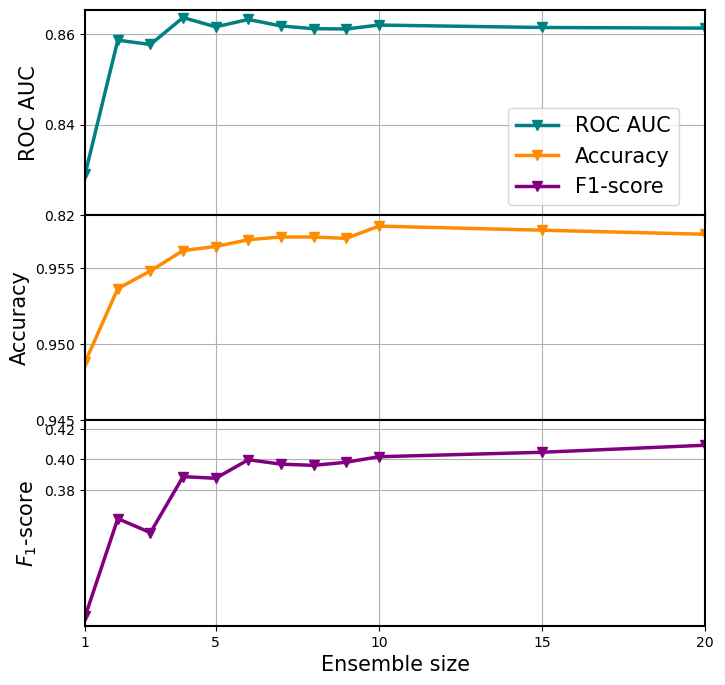

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [7]:
ens_num = 15
results_full = pd.read_csv(f'results/ensemble/medpfn_medium_maxens{ens_num}')
#for i in range(ens_num):
x = enses = [1,2,3,4,5,6,7,8,9,10,15,20,25,40,50]
acc = results_full.iloc[:,1]
acc_error = results_full.iloc[:,2]
roc = results_full.iloc[:,7]
roc_error = results_full.iloc[:,8]
f1 = results_full.iloc[:,9]
f1_error = results_full.iloc[:,10]

heights = [1,1,1]
mpl.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(3, 1, figsize=(8, 8), gridspec_kw={'height_ratios': heights},sharex=True)

colors = ["teal", "darkorange", "purple"]
#ax[0].fill_between(x, roc - roc_error, roc + roc_error, alpha=0.25, color=colors[0])
#ax[1].fill_between(x, acc - acc_error, acc + acc_error, alpha=0.25,color=colors[1])
#ax[2].fill_between(x, f1 - f1_error, f1 + f1_error, alpha=0.25, color=colors[2])
ax[1].plot(x, acc, marker="v", linewidth=2.5, markersize=7.0, label='Accuracy', c=colors[1])
ax[0].plot(x, roc, marker="v", linewidth=2.5, markersize=7.0, label='ROC AUC', c=colors[0])
ax[2].plot(x, f1, marker="v", linewidth=2.5, markersize=7.0, label='F1-score', color=colors[2])

#ax[0].set_ylim(0.85,0.95)
#ax[1].set_ylim(0.945,0.955)
#ax[2].set_ylim(0.15,0.35)
ax[0].set_yticks([0.82,0.84,0.86])
ax[1].set_yticks([0.945,0.95,0.955])
ax[2].set_yticks([0.38,0.4,0.42])
# Adding labels and title
ax[0].set_ylabel('ROC AUC', fontsize=15)
ax[1].set_ylabel('Accuracy', fontsize=15)
ax[2].set_ylabel('$F_1$-score', fontsize=15)
ax[2].set_xlabel('Ensemble size', fontsize=15)
ax[2].set_xticks([1,5,10,15,20])
#plt.yticks([0.3,0.6,0.9])
ax[2].set_xlim(1,20)
#plt.ylim(0,1)
ax[0].grid()
ax[1].grid()
ax[2].grid()
#plt.ylabel('Metric score')
#plt.title('Plot with Uncertainty Band')
fig.legend(loc=(0.7,0.7), fontsize=15)
plt.subplots_adjust(hspace=0)
#plt.tight_layout()
plt.show()
fig.savefig("results/plots/ensemble.eps")

## Finetuning analysis ##

In [ ]:
save = True
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
preprocess = "mix"
multi_decoder = "permutation"
N_ens = 5
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "small_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## good start, best with ftpath = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
path = dir_path + f"/logs/trainrun_{run_name}"
ens_num = 10

    
reducer  = AnovaSelect()

results_mean = pd.DataFrame(np.zeros((ens_num, len(metrics)+1)),
                            index=np.arange(1,1+ens_num),
                            columns=metrics+["runtime"])
results_std = pd.DataFrame(np.zeros((ens_num, len(metrics)+1)), 
                           index=np.arange(1,1+ens_num),
                           columns=metrics+["runtime"])

lrs = np.arange(0,105,5)
size = min(labels.shape[0],np.floor(max_samples*(cv/(cv-1))))
runs = int(all_data.shape[0]//size)
data_sections, label_sections = stratified_split(all_data, labels,cv=runs)


for ens in range(len(lrs)):
    print(ens)
    for section in range(runs):
    #print(section)
        model = MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  preprocess_mode=preprocess,
                ft_epochs=lrs[ens], ft_lr=ft_lr)
        out_mean, out_std = cross_validate_sample(
            model, data_sections[section], label_sections[section], metrics, strat_split, cv, sampling, 
            reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
            recomp=recomp)
        results_mean.iloc[ens,:] += out_mean
        results_std.iloc[ens,:] += out_std
results_mean=results_mean/runs
results_std=results_std/runs
    
results_mean = results_mean.add_suffix(" mean")
results_std = results_std.add_suffix(" std")
results_full = pd.concat((results_mean, results_std), axis=1)
cols = results_full.columns.tolist()
new_cols = []
for i in range(int(len(cols)/2)):
    new_cols.append(cols[i])
    new_cols.append(cols[i+int(len(cols)/2)])
results_full = results_full[new_cols]
red_name = "finetuning"
if save:
    directory = f"results/{red_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    save_path = f'results/{red_name}/2new_medpfn_maxsteps{ens_num}_lr{ft_lr}'
    results_full.to_csv(save_path)
print("\n", "\n", red_name, "\n", results_full.round(3))
    #print(results_full.sort_values("roc_auc mean").round(3))

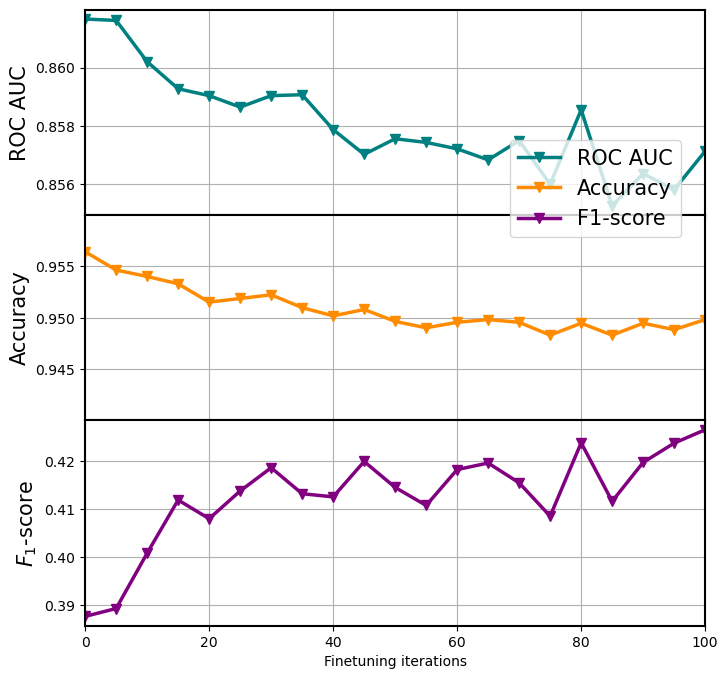

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [9]:
ens_num = 21
results_full = pd.read_csv(f'results/finetuning/2new_medpfn_medium_maxsteps{ens_num}_lr{1e-05}')
#for i in range(ens_num):
x = np.arange(0,ens_num)*5
acc = results_full.iloc[:,1]
acc_error = results_full.iloc[:,2]
roc = results_full.iloc[:,7]
roc_error = results_full.iloc[:,8]
f1 = results_full.iloc[:,9]
f1_error = results_full.iloc[:,10]

heights = [1,1,1]
mpl.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(3, 1, figsize=(8, 8), gridspec_kw={'height_ratios': heights},sharex=True)

colors = ["teal", "darkorange", "purple"]
#ax[0].fill_between(x, roc - roc_error, roc + roc_error, alpha=0.25, color=colors[0])
#ax[1].fill_between(x, acc - acc_error, acc + acc_error, alpha=0.25,color=colors[1])
#ax[2].fill_between(x, f1 - f1_error, f1 + f1_error, alpha=0.25, color=colors[2])
ax[1].plot(x, acc, marker="v", linewidth=2.5, markersize=7.0, label='Accuracy', c=colors[1])
ax[0].plot(x, roc, marker="v", linewidth=2.5, markersize=7.0, label='ROC AUC', c=colors[0])
ax[2].plot(x, f1, marker="v", linewidth=2.5, markersize=7.0, label='F1-score', color=colors[2])

#ax[0].set_ylim(0.9,0.94)
ax[1].set_ylim(0.94,0.96)
#ax[2].set_ylim(0.2,0.6)
#ax[0].set_yticks([0.9,0.92,0.94])
ax[1].set_yticks([0.945,0.95, 0.955])
#ax[2].set_yticks([0.2,0.4])
# Adding labels and title
ax[2].set_xlabel('Finetuning iterations')
ax[0].set_ylabel('ROC AUC', fontsize=15)
ax[1].set_ylabel('Accuracy', fontsize=15)
ax[2].set_ylabel('$F_1$-score', fontsize=15)
#ax[2].set_xticks(np.arange(0,50,10))
#plt.yticks([0.3,0.6,0.9])
ax[2].set_xlim(0,100)
#plt.ylim(0,1)
ax[0].grid()
ax[1].grid()
ax[2].grid()
#plt.ylabel('Metric score')
#plt.title('Plot with Uncertainty Band')
fig.legend(loc=(0.7,0.65), fontsize=15)
plt.subplots_adjust(hspace=0)
#plt.tight_layout()
plt.show()
fig.savefig("results/plots/finetuning.eps")

### Feature removal ###

In [ ]:
save = True
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 20
ft_epochs_forest = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 5
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"


models = [
    MajorityClass(),
    #XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=1, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process,
                    ft_epochs=ft_epochs, ft_lr=ft_lr),
    RandomForestClassifier(),
    #AutoGluon(),
    #CatBoostGrid(),
    #XGBoostGrid(),
    LogisticRegressionClassifier(), 
    TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs_forest)
]
reducer  = AnovaSelect()
#for reducer in [AnovaSelect(), RandomSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
#data = clr(all_data)

#all_data = normalize(all_data)
to_delete = [0,1,5,10,25,50,100,250,500]
for best_delete in to_delete:
    results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                index=[m.__class__.__name__ for m in models],
                                columns=metrics+["runtime"])
    results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                               index=[m.__class__.__name__ for m in models],
                               columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
            model, all_data, labels, metrics, strat_split, cv, sampling, 
            reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
            recomp=recomp)
    
    results_mean = results_mean.add_suffix(" mean")
    results_std = results_std.add_suffix(" std")
    results_full = pd.concat((results_mean, results_std), axis=1)
    cols = results_full.columns.tolist()
    new_cols = []
    for i in range(int(len(cols)/2)):
        new_cols.append(cols[i])
        new_cols.append(cols[i+int(len(cols)/2)])
    results_full = results_full[new_cols]
    red_name = "feature_removal"
    if save:
        directory = f"results/{red_name}"
        if not os.path.exists(directory):
            os.makedirs(directory)
        save_path = f'results/{red_name}/best_delete{best_delete}.csv'
        results_full.to_csv(save_path)
    print("\n", "\n", best_delete, "\n", results_full.round(3))
    #print(results_full.sort_values("roc_auc mean").round(3))

## New data

In [16]:
path = "datasets/external_pdac.csv"
df = pd.read_csv(path)
df_data = df.iloc[:,2:-5]
data = df_data.to_numpy()
labels = df["Disease"].to_numpy()
labels[labels=="Healthy"] = 0
labels[labels=="PDAC"] = 1
all_data = data
data_c0 = data[labels==0]
data_c1 = data[labels==1]
num_c1 = data_c1.shape[0]
num_c0 = int(num_c1*0.06)
data = np.concatenate((data_c0[:num_c0], data_c1), axis=0)
labels = np.concatenate((np.zeros(num_c0), np.ones(num_c1)))
all_data, labels = unison_shuffled_copies(data, labels)
all_data = data_to_comp(all_data)

In [31]:
all_data = []
all_labels = []
for p in ["datasets/CRC_AUS_LOSO.csv", 
          "datasets/CRC_FRA_LOSO.csv",
         "datasets/CRC_CHI_LOSO.csv",
         "datasets/CRC_GER_LOSO.csv",
         #"datasets/CRC_IND_additional.csv",
         "datasets/CRC_USA_LOSO.csv"]:
    df = pd.read_csv(p)
    df_binary = df.loc[(df["disease"] == "healthy") | (df["disease"]=="CRC")]
    df_data = df_binary.iloc[:,4:]
    data = df_data.to_numpy()
    labels = df_binary["disease"].to_numpy()
    labels[labels=="healthy"] = 0
    labels[labels=="CRC"] = 1
    data = (1/np.sum(data, axis=1, keepdims=True))*data
    all_data.append(data)
    all_labels.append(labels)

all_data = np.concatenate(all_data,axis=0)
labels = np.concatenate(all_labels)
all_data, labels = unison_shuffled_copies(all_data, labels, seed=412)
data = all_data
data_c0 = data[labels==0]
data_c1 = data[labels==1]
num_c1 = data_c1.shape[0]
num_c0 = int(num_c1*0.03)
data = np.concatenate((data_c0[:num_c0], data_c1), axis=0)
labels = np.concatenate((np.zeros(num_c0), np.ones(num_c1)))
all_data, labels = unison_shuffled_copies(data, labels)
all_data = data_to_comp(all_data)

In [32]:
print(all_data.shape)
print(np.sum(all_data,axis=1))
print(np.mean(1*(labels==1)))

(1467, 849)
[1. 1. 1. ... 1. 1. 1.]
0.9713701431492843


In [34]:
save = False
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 0
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
preprocess = "false"
multi_decoder = "permutation"
N_ens = 10
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_net_mlp_balance_bsplit_baseline" ## NO PERM, VERY ROBUST
#run_name2 = "large_mlp_var_balance_05weight_anova" ## das aller bestigste
run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## das aller bestigste
run_name2 = "small_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## das aller bestigste ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_200" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_longer" ## das aller bestigste
#run_name = "medium_mlp_balance_lownoisefixparam_anova"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight" ## WORKS VERY WELL WITH PERM
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
path2 = dir_path + f"/logs/trainrun_{run_name2}"
filename = "model"


models = [
    #CatBoostOptim(n_optim=cat_optim),
    MajorityClass(),
    XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  preprocess_mode=preprocess),
    #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  preprocess_mode=preprocess, ft_epochs=ft_epochs, ft_lr=ft_lr),
    MedPFNClassifier(base_path=path2, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  preprocess_mode=preprocess),
    #MedPFNClassifier(base_path=path2, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  preprocess_mode=preprocess, ft_epochs=ft_epochs, ft_lr=ft_lr),
    RandomForestClassifier(),
    #AutoGluon(),
    #CatBoostGrid(),
    #XGBoostGrid(),
    #XGBoostOptim(n_optim=n_optim),
    LogisticRegression(max_iter=1000), 
    TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=False),
    #TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs)
]

for reducer in [AnovaSelect(), RandomSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
    results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                index=[m.__class__.__name__ for m in models],
                                columns=metrics+["runtime"])
    results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                               index=[m.__class__.__name__ for m in models],
                               columns=metrics+["runtime"])
    reducer.fit(all_data, labels)
    print(np.sort(reducer.anova.scores_))
    for ii, model in enumerate(models):
        results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
            model, all_data, labels, metrics, strat_split, cv, sampling, 
            reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
            recomp=recomp)

    results_mean = results_mean.add_suffix(" mean")
    results_std = results_std.add_suffix(" std")
    results_full = pd.concat((results_mean, results_std), axis=1)
    cols = results_full.columns.tolist()
    new_cols = []
    for i in range(int(len(cols)/2)):
        new_cols.append(cols[i])
        new_cols.append(cols[i+int(len(cols)/2)])
    results_full = results_full[new_cols]
    red_name = reducer.__class__.__name__
    if save:
        directory = f"results/{red_name}"
        if not os.path.exists(directory):
            os.makedirs(directory)
        save_path = f'results/{red_name}/baseline_cv{cv}_mxsamp{max_samples}_sd{seed}_ovrw{int(overwrite)}'
        results_full.to_csv(save_path)
    print("\n", "\n", red_name, "\n", results_full.round(3))
    #print(results_full.sort_values("roc_auc mean").round(3))

C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [258] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\lenna\anaconda3\envs\master7\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[1.22031259e-05 2.36409440e-05 6.87567954e-05 7.02291007e-05
 1.17532251e-04 1.68471697e-04 1.92339541e-04 2.11053521e-04
 3.16823677e-04 3.39999892e-04 3.79957814e-04 4.29398836e-04
 7.44640170e-04 8.97235024e-04 9.18975719e-04 1.00615144e-03
 1.20056238e-03 1.35669082e-03 1.40982091e-03 1.53017553e-03
 1.76033757e-03 2.14786944e-03 2.21908537e-03 2.28164749e-03
 2.92382457e-03 3.00008627e-03 3.16960022e-03 3.40414354e-03
 3.52487515e-03 3.69671351e-03 3.72808213e-03 4.53669677e-03
 4.76309093e-03 5.25588892e-03 5.72247355e-03 6.07351944e-03
 6.09735707e-03 6.27132291e-03 6.78350939e-03 7.22452053e-03
 7.23081639e-03 8.50892854e-03 8.89850924e-03 9.53465313e-03
 9.64378543e-03 1.00643584e-02 1.00878351e-02 1.04050908e-02
 1.10011598e-02 1.11988276e-02 1.13696490e-02 1.14861876e-02
 1.23869445e-02 1.26433631e-02 1.28093926e-02 1.28484760e-02
 1.29899890e-02 1.44270959e-02 1.45117112e-02 1.54919204e-02
 1.57548678e-02 1.58807296e-02 1.62724440e-02 1.69049805e-02
 1.77836630e-02 1.812242


KeyboardInterrupt



In [ ]:
save = False
sampling = None
cv = 10
best_delete = 0
strat_split = True
recomp = False
n_optim = 1000
cat_optim = 10
ft_epochs = 20
ft_epochs_forest = 10
ft_lr = 1e-5
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 5
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
#run_name = "medium_net_mlp_balance_bsplit_baseline" ## NO PERM, VERY ROBUST
#run_name2 = "large_mlp_var_balance_05weight_anova" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_newprior" ## das aller bestigste
run_name = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100" ## good start, best with ft
#run_name3 = "medium_mlp_var_balance_05weight_anova_bestwithnoisebnn_100_moreweight" ## best start, ft no so good
#run_name = "medium_mlp_var_balance_05weight_anova_200" ## das aller bestigste
#run_name = "medium_mlp_var_balance_05weight_anova_longer" ## das aller bestigste
#run_name = "medium_mlp_balance_lownoisefixparam_anova"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight" ## WORKS VERY WELL WITH PERM
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
#path2 = dir_path + f"/logs/trainrun_{run_name2}"
#path3 = dir_path + f"/logs/trainrun_{run_name3}"
filename = "model"


models = [
    MajorityClass(),
    XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=1, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process,
                    ft_epochs=ft_epochs, ft_lr=ft_lr),
    RandomForestClassifier(),
    #AutoGluon(),
    #CatBoostGrid(),
    #XGBoostGrid(),
    LogisticRegressionClassifier(), 
    #TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    #TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs_forest)
]
reducer  = AnovaSelect()
#for reducer in [AnovaSelect(), RandomSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
#data = clr(all_data)

#all_data = normalize(all_data)

results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                            index=[m.__class__.__name__ for m in models],
                            columns=metrics+["runtime"])
results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                           index=[m.__class__.__name__ for m in models],
                           columns=metrics+["runtime"])

for ii, model in enumerate(models):
    results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
        model, all_data, labels, metrics, strat_split, cv, sampling, 
        reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete,
        recomp=recomp)

results_mean = results_mean.add_suffix(" mean")
results_std = results_std.add_suffix(" std")
results_full = pd.concat((results_mean, results_std), axis=1)
cols = results_full.columns.tolist()
new_cols = []
for i in range(int(len(cols)/2)):
    new_cols.append(cols[i])
    new_cols.append(cols[i+int(len(cols)/2)])
results_full = results_full[new_cols]
red_name = reducer.__class__.__name__
if save:
    directory = f"results/{red_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    save_path = f'results/{red_name}/baseline_cv{cv}_mxsamp{max_samples}_sd{seed}_ovrw{int(overwrite)}.csv'
    results_full.to_csv(save_path)
print("\n", "\n", red_name, "\n", results_full.round(3))
#print(results_full.sort_values("roc_auc mean").round(3))

In [ ]:
save = True
sampling = None
cv = 7
best_delete = 0
strat_split = True
n_optim = 1000
cat_optim = 10
ft_epochs = 10
ft_lr = 1e-7
max_s = 1024
max_q = 128
max_samples = 1024
no_pre_process = False
multi_decoder = "permutation"
N_ens = 7
seed = 42
overwrite = True
metrics = ["accuracy", "precision", "recall", "roc_auc", "f1"]
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_net_mlp_balance_bsplit_baseline" ## NO PERM, VERY ROBUST
run_name = "medium_mlp_var_balance_05weight_anova" ### BEST!!!!!! ####
#run_name = "medium_mlp_balance_lownoisefixparam_anova"
#run_name = "medium_mlp_0.5static_balance_anova"
#run_name = "large_mlp_fullbalance"
#run_name = "small_net_mlp_var_imbalance_05weight" ## WORKS VERY WELL WITH PERM
#run_name = "small_net_mlp_varbalance_weight_batchunisplit"
#run_name = "small_net_mlp_variable_balance_weight"
#run_name = "small_net_mlp_balance_minevalup"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
models = [
    #CatBoostOptim(n_optim=cat_optim),
    XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
    MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
    RandomForestClassifier(),
    #XGBoostOptim(n_optim=n_optim),
    LogisticRegression(max_iter=1000), 
    TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
    TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs)
]

#for reducer in [AnovaSelect(), NonZeroSelect(), MeanSelect(), StdSelect(), MaxSelect(), PCASelect()]:
reducer = AnovaSelect()
#for reduce_data in [top_anova, top_non_zero, top_mean, top_std, top_max, pca_reduce]:
    #data = reduce_data(all_data, labels, 100)
    #print(all_data.shape)
for best_delete in range(0,510,10):
    #reducer.k = 100
    #reducer = None
    results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                index=[m.__class__.__name__ for m in models],
                                columns=metrics+["runtime"])
    results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                               index=[m.__class__.__name__ for m in models],
                               columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(
            model, all_data, labels, metrics, strat_split, cv, sampling, 
            reducer, max_samples, seed=seed, overwrite=overwrite, n_best_delete=best_delete)

    results_mean = results_mean.add_suffix(" mean")
    results_std = results_std.add_suffix(" std")
    results_full = pd.concat((results_mean, results_std), axis=1)
    cols = results_full.columns.tolist()
    new_cols = []
    for i in range(int(len(cols)/2)):
        new_cols.append(cols[i])
        new_cols.append(cols[i+int(len(cols)/2)])
    results_full = results_full[new_cols]
    red_name = "feature_select_shift_10step"
    if save:
        directory = f"results/{red_name}"
        if not os.path.exists(directory):
            os.makedirs(directory)
        save_path = f'results/{red_name}/{best_delete}_cv{cv}_mxsamp{max_samples}_sd{seed}_ovrw{int(overwrite)}'
        results_full.to_csv(save_path)
    print("\n", "\n", red_name, "\n", results_full.round(3))

In [ ]:
ws = 20
rocs = []
f1s = []
for i in range(0,510,10):
    results = pd.read_csv(f'results/feature_select_shift_10step/{i}_cv{7}_mxsamp{1024}_sd{42}_ovrw{1}')
    rocs.append(results["roc_auc mean"].values)
    f1s.append(results["f1 mean"].values)
rocs = np.array(rocs)
f1s = np.array(f1s)
labels = results.iloc[:,0].values
plt.figure(figsize=(12,3), dpi=200)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
colors = []
for cl in range(rocs.shape[1]):
    ax1.plot(np.arange(rocs.shape[0]-ws+1)*10, moving_average(rocs[:,cl], ws), label=labels[cl])
    ax2.plot(np.arange(rocs.shape[0]-ws+1)*10, moving_average(f1s[:,cl], ws), label=labels[cl])
plt.suptitle("ROC AUC and F1-Score shifting feature selection")
#ax1.set_title("ROC AUC")
ax1.set_ylabel("ROC AUC")
#ax2.set_title("F1-Score")
ax2.set_xlabel("feature shift")
ax2.set_ylabel("F1")
ax1.legend(fontsize=7)
plt.show()

In [ ]:
counts = np.count_nonzero(all_data, axis=0)
counts = 1-counts/all_data.shape[0]
means = np.mean(all_data, axis=0)
plt.scatter(counts, means, s=1)
plt.show()
plt.scatter(counts, np.max(all_data, axis=0), s=1)

In [ ]:
print(error)

In [ ]:
dir_path = os.path.abspath(os.getcwd())
run_name = "medium_net_mlp_balance_bsplit_baseline"
run_name = "medium_net_mlp_balance_bsplit_baseline_longer"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
for sampling in [None]:#, undersample]:
    cv = 5
    strat_split = True
    n_optim = 1000
    cat_optim = 10
    ft_epochs = 10
    ft_lr = 1e-8
    max_s = 1024
    max_q = 128
    max_samples = None
    no_pre_process = False
    multi_decoder = None
    N_ens = 5
    metrics = ["accuracy", "precision", "recall", "roc_auc"]
    models = [
        #CatBoostOptim(n_optim=cat_optim),
        #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder, ft_epochs=ft_epochs, ft_lr=ft_lr,
        #                 max_s=max_s, max_q=max_q, no_preprocess_mode=no_pre_process),
        MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=N_ens, multiclass_decoder=multi_decoder,  no_preprocess_mode=no_pre_process),
        #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=5, no_preprocess_mode=True),
        XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
        XGBoostOptim(n_optim=n_optim),
        LogisticRegression(max_iter=500), 
        TabPFNClassifier(device='cpu', N_ensemble_configurations=5, no_preprocess_mode=no_pre_process),
        TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs)
    ]
    results_mean = pd.DataFrame(np.zeros((len(models), len(metrics)+1)),
                                index=[m.__class__.__name__ for m in models],
                                columns=metrics+["runtime"])
    results_std = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                               index=[m.__class__.__name__ for m in models],
                               columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results_mean.iloc[ii,:], results_std.iloc[ii,:] = cross_validate_sample(model, data, labels, metrics, strat_split, cv, sampling, max_samples)
    #results_sorted = results.sort_values("roc_auc")
    #print(results_sorted)
    print(results_mean)
    print(results_std)

In [ ]:
cols = []
for m in metrics + "runtime":
    cols.append(m)
    cols.append(m+" std")

In [ ]:

dir_path = os.path.abspath(os.getcwd())
run_name = "medium_net_mlp_balance_bsplit_baseline"
path = dir_path + f"/logs/trainrun_{run_name}"
filename = "model"
#model, config = load_model(path, filename, device="cpu", eval_positions=None, verbose=0)
#pred_model = TabPFNClassifier(model[2], config, device="cpu", N_ensemble_configurations=5, no_preprocess_mode=False)
for sampling in [None]:
    cv = 3
    strat_split = True
    n_optim = 10
    ft_epochs = 10
    max_samples = None
    metrics = metrics = ["accuracy", "precision", "recall", "roc_auc"]
    models = [
        RandomForestClassifier()
        #CatBoostOptim(n_optim=n_optim),
        #pred_model,
        #MedPFNClassifier(base_path=path, filename=filename, device='cpu', N_ensemble_configurations=3, no_preprocess_mode=True),
        #XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
        #XGBoostOptim(n_optim=n_optim),
        #LogisticRegression(max_iter=500), 
        #TabPFNClassifier(device='cpu', N_ensemble_configurations=3, no_preprocess_mode=True),
        #TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml", max_epochs=ft_epochs)
    ]
    results = pd.DataFrame(np.zeros((len(models), len(metrics)+1)), 
                           index=[m.__class__.__name__ for m in models],
                          columns=metrics+["runtime"])
    
    for ii, model in enumerate(models):
        results.iloc[ii,:] = cross_validate_sample(model, data, labels, metrics, strat_split, cv, sampling, max_samples)
    results_sorted = results.sort_values("roc_auc")
    
    print(results_sorted)

In [ ]:
print(results_sorted)